In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import datetime

In [29]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [30]:
dataset = pd.read_csv('../dataset/time_series/sunspots/Sunspots.csv', 
                      parse_dates=["Date"], 
                      index_col=["Date"])

dataset.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


In [31]:
dataset.columns

Index(['Unnamed: 0', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [32]:
dataset.drop(dataset.columns[0], axis=1, inplace=True)

In [33]:
dataset.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [34]:
dataset.isna().sum()

Monthly Mean Total Sunspot Number    0
dtype: int64

In [35]:
dataset["target"] = dataset["Monthly Mean Total Sunspot Number"]

In [36]:
dataset.head()

,Monthly Mean Total Sunspot Number,target
Date,,
1749-01-31,96.7,96.7
1749-02-28,104.3,104.3
1749-03-31,116.7,116.7
1749-04-30,92.8,92.8
1749-05-31,141.7,141.7


In [37]:
dataset.rename(columns={dataset.columns[0]:"mean_sunspot"}, inplace=True)

In [38]:
dataset.head()

,mean_sunspot,target
Date,,
1749-01-31,96.7,96.7
1749-02-28,104.3,104.3
1749-03-31,116.7,116.7
1749-04-30,92.8,92.8
1749-05-31,141.7,141.7


In [39]:
def multivariate_trailing_window(data, num_targets, window_size, horizon):
    """
    Generate multivariate trailing windows for time series prediction.

    Parameters:
    - data: pandas DataFrame, input time series data with columns representing features and targets
    - window_size: int, size of the trailing window
    - horizon: int, number of steps to forecast into the future
    - num_targets: int, number of target variables

    Returns:
    - X: numpy array, input features (shape: [num_samples - window_size - horizon + 1, window_size, num_features])
    - y: numpy array, target values (shape: [num_samples - window_size - horizon + 1, horizon, num_targets])
    """

    num_samples = len(data)
    num_features = data.shape[1] - num_targets  # Subtract num_targets for target columns

    X, y = [], []

    for i in range(num_samples - window_size - horizon + 1):
        X.append(data.iloc[i:i + window_size, :-num_targets].values)
        y.append(data.iloc[i + window_size:i + window_size + horizon, -num_targets:].values.reshape(-1, num_targets))

    return np.array(X), np.array(y)

In [40]:
# Callbacks

def tensorboard_cb(dirpath, model_name):
    return tf.keras.callbacks.TensorBoard(os.path.join(dirpath, 
                                                       model_name, 
                                                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

def checkpoint_cb(dirpath, model_name, save_format=None, save_weights=False):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(dirpath, model_name + save_format), 
                                              save_best_only=True, 
                                              save_weights_only=save_weights,
                                              monitor="val_loss",
                                              verbose=1)

def early_stopping_cb(patience):
    return tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            restore_best_weights=True, 
                                            patience=patience,
                                            verbose=1)

def reduce_lr_cb(patience, factor):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                patience=patience, 
                                                factor=factor, 
                                                min_lr=1e-7,
                                                verbose=1)

def lr_scheduler_cb(lr_init, lr_div):
    return tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_init * 10 ** (epoch/lr_div))

In [41]:
WINDOW = 36
HORIZON = 1

In [42]:
X, y = multivariate_trailing_window(dataset, 1, WINDOW, HORIZON)

In [43]:
X.shape, y.shape

((3199, 36, 1), (3199, 1, 1))

In [44]:
X[0]

array([[ 96.7],
       [104.3],
       [116.7],
       [ 92.8],
       [141.7],
       [139.2],
       [158. ],
       [110.5],
       [126.5],
       [125.8],
       [264.3],
       [142. ],
       [122.2],
       [126.5],
       [148.7],
       [147.2],
       [150. ],
       [166.7],
       [142.3],
       [171.7],
       [152. ],
       [109.5],
       [105.5],
       [125.7],
       [116.7],
       [ 72.5],
       [ 75.5],
       [ 94. ],
       [101.2],
       [ 84.5],
       [110.5],
       [ 99.7],
       [ 39.2],
       [ 38.7],
       [ 47.5],
       [ 73.3]])

In [45]:
y = np.squeeze(y, axis=-1)

In [46]:
y.shape

(3199, 1)

In [47]:
y[0]

array([58.3])

In [48]:
y[:3]

array([[ 58.3],
       [ 83.3],
       [118.3]])

In [49]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_val, y_val = X[split_size:], y[split_size:]

In [51]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [50]:
def scale_2d_3d_data(data, scaler=None, norm=False, stand=False):
    """
    Scale 2D or 3D data using Min-Max scaling or standardization.

    Parameters:
    - data: numpy array, input data (2D or 3D)
    - norm: bool, whether to perform Min-Max scaling
    - stand: bool, whether to perform standardization

    Returns:
    - If norm=True: Tuple of (scaler, scaled_data)
    - If stand=True: Tuple of (scaler, standardized_data)
    - If neither norm nor stand is True: None
    """

    original_shape = data.shape if len(data.shape) == 3 else None

    # Check if the input data is 3D, and reshape to 2D if necessary
    if original_shape:
        data = data.reshape((original_shape[0] * original_shape[1], original_shape[2]))

    scaler = scaler
    scaled_data = None

    if norm:
        if scaler is None:
            # Min-Max scaling
            scaler = MinMaxScaler().fit(data)
        scaled_data = scaler.transform(data)

    elif stand:
        if scaler is None:
            # Standardization
            scaler = StandardScaler().fit(data)
        scaled_data = scaler.transform(data)

    # Reshape the scaled data back to 3D if the input was originally 3D
    if original_shape and scaled_data is not None:
        scaled_data = scaled_data.reshape(original_shape)

    return scaler, scaled_data

In [52]:
x_scalar, X_train_scaled = scale_2d_3d_data(X_train, norm=True)
y_scalar, y_train_scaled = scale_2d_3d_data(y_train, norm=True)

In [53]:
_, X_val_scaled = scale_2d_3d_data(X_val, scaler=x_scalar, norm=True)
_, y_val_scaled = scale_2d_3d_data(y_val, scaler=y_scalar, norm=True)

In [64]:
X_train_scaled.shape, y_train_scaled.shape

((2559, 36, 1), (2559, 1))

In [65]:
X_val_scaled.shape, y_val_scaled.shape

((640, 36, 1), (640, 1))

In [66]:
y_val_scaled[0]

array([0.02561527])

In [67]:
X_val_scaled[0]

array([[0.16549473],
       [0.15544952],
       [0.14967353],
       [0.07885485],
       [0.07910598],
       [0.18257157],
       [0.14088398],
       [0.09743847],
       [0.08337519],
       [0.07207433],
       [0.08839779],
       [0.06228026],
       [0.10472125],
       [0.15344048],
       [0.1285786 ],
       [0.07207433],
       [0.11928679],
       [0.13862381],
       [0.12581617],
       [0.08463084],
       [0.0542441 ],
       [0.0567554 ],
       [0.06353591],
       [0.06052235],
       [0.03239578],
       [0.0359116 ],
       [0.03390256],
       [0.01205424],
       [0.03465595],
       [0.01757911],
       [0.02310397],
       [0.02787544],
       [0.05549975],
       [0.06378704],
       [0.05223506],
       [0.04394776]])

In [54]:
def create_performant_features_targerts(features, targets, batch_size=32, pre=False, func=None, shuffle=False, shuffle_size=None):
    """
    Create performant dataset for escalating efficiency during training/evaluating a model.
    """
    features_tensor = tf.data.Dataset.from_tensor_slices(tf.cast(features, dtype=tf.float32))
    targets_tensor = tf.data.Dataset.from_tensor_slices(tf.cast(targets, dtype=tf.float32))
    dataset_tensor = tf.data.Dataset.zip((features_tensor, targets_tensor))
    if pre:
        dataset_tensor = dataset_tensor.map(map_func=func, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset_tensor = dataset_tensor.shuffle(shuffle_size)
    dataset_tensor = dataset_tensor.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset_tensor

In [55]:
train_dataset = create_performant_features_targerts(X_train_scaled, y_train_scaled)
val_dataset = create_performant_features_targerts(X_val_scaled, y_val_scaled)

In [56]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 36, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [57]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 36, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [37]:
tf.keras.backend.clear_session()

In [38]:
from tensorflow.keras import layers

In [42]:
inputs = layers.Input(shape=(WINDOW, 1), dtype=tf.float32)
x = layers.Conv1D(64, 3, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(72, activation="relu", return_sequences=True)(x)
x = layers.LSTM(48, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(HORIZON)(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [43]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 34, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 64)            12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 7, 72)             3945

In [44]:
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))

model_1_history = model_1.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=150,
                              callbacks=[tensorboard_cb("model_logs/sunspot/", model_1.name),
                                         checkpoint_cb("h5_models/sunspot/", model_1.name, save_format=".h5"),
                                         reduce_lr_cb(patience=3, factor=0.1),
                                         early_stopping_cb(patience=5)])

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 0.1319
Epoch 1: val_loss improved from inf to 0.11924, saving model to h5_models/sunspot\model_1.h5
80/80 [==============================] - 8s 55ms/step - loss: 0.1319 - val_loss: 0.1192 - lr: 3.0000e-04
Epoch 2/150
80/80 [==============================] - ETA: 0s - loss: 0.1071
Epoch 2: val_loss improved from 0.11924 to 0.10623, saving model to h5_models/sunspot\model_1.h5
80/80 [==============================] - 4s 49ms/step - loss: 0.1071 - val_loss: 0.1062 - lr: 3.0000e-04
Epoch 3/150
79/80 [============================>.] - ETA: 0s - loss: 0.0978
Epoch 3: val_loss improved from 0.10623 to 0.09854, saving model to h5_models/sunspot\model_1.h5
80/80 [==============================] - 4s 51ms/step - loss: 0.0971 - val_loss: 0.0985 - lr: 3.0000e-04
Epoch 4/150
79/80 [============================>.] - ETA: 0s - loss: 0.0910
Epoch 4: val_loss improved from 0.09854 to 0.08727, saving model to h5_models/sunspot\model_1.

In [45]:
model_1.evaluate(train_dataset), model_1.evaluate(val_dataset)

20/20 [==============================] - 0s 8ms/step - loss: 0.0558


(0.054604820907115936, 0.05575523525476456)

In [46]:
y_val_scaled.dtype

dtype('float64')

In [47]:
model_1_preds = model_1.predict(val_dataset)
model_1_preds.dtype

dtype('float32')

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [49]:
def evaluate_ts_rg_model(actual_values, predicted_values):
    """
    Evaluate a time series/regression model for forecasting population.

    Parameters:
    - actual_values: 1D array or list of actual population values.
    - predicted_values: 1D array or list of predicted population values.

    Returns:
    - evaluation_results: Dictionary containing evaluation metrics.
    """
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mask = actual_values != 0  # Avoid division by zero
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100

    # R-squared (R2)
    r2 = r2_score(actual_values, predicted_values)

    evaluation_results = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

    return evaluation_results

In [50]:
model_1_results_scaled = evaluate_ts_rg_model(tf.cast(tf.squeeze(y_val_scaled), dtype=tf.float32), tf.squeeze(model_1_preds))
model_1_results_scaled

C:\Users\yihim\AppData\Local\Temp\ipykernel_3832\3564251472.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100


{'MAE': 0.05575524,
 'MSE': 0.0056552673,
 'RMSE': 0.07520151,
 'MAPE': 67.3210859298706,
 'R2': 0.8073095350923589}

In [51]:
model_1_results = evaluate_ts_rg_model(tf.cast(tf.squeeze(y_scalar.inverse_transform(y_val_scaled)), dtype=tf.float32), tf.squeeze(y_scalar.inverse_transform(model_1_preds)))
model_1_results

C:\Users\yihim\AppData\Local\Temp\ipykernel_3832\3564251472.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100


{'MAE': 22.201736,
 'MSE': 896.71747,
 'RMSE': 29.945242,
 'MAPE': 67.32107996940613,
 'R2': 0.807309535156548}

In [52]:
offset = np.abs(24-len(model_1_preds))
offset

616

In [53]:
def plot_ts_rg_preds_interval(y_true, y_preds, offset, figsize=(10, 7)):
    """
    Plot a graph with a defined offset to visualize the 95% confidence of the model's predictions versus actual.
    
    Parameters:
    - y_true: 1D array or list of actual values.
    - y_preds: 1D array or list of predicted values.
    - offset: The duration to visualize.
    """
    residuals = y_true - y_preds
    standard_errors = np.std(residuals)
    margin_of_errors = 1.96 * standard_errors
    upper = y_preds + margin_of_errors
    lower = y_preds - margin_of_errors

    plt.figure(figsize=figsize)
    plt.plot(y_true[offset:], label="Actual", color="green")
    plt.plot(y_preds[offset:], label="Preds", color="blue")
    plt.fill_between(range(len(y_true[offset:])), lower[offset:], upper[offset:], color="lightgrey", label="Preds Interval")
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.xlabel("Duration")
    plt.ylabel("Targets")

In [54]:
y_val_unscaled = tf.cast(tf.squeeze(y_scalar.inverse_transform(y_val_scaled)), dtype=tf.float32)
model_1_preds_unscaled = tf.squeeze(y_scalar.inverse_transform(model_1_preds))

In [55]:
y_val_unscaled[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([10.2, 34.5, 23.3, 17.3, 13.3], dtype=float32)>

In [56]:
model_1_preds_unscaled[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([16.042837 , 15.335711 , 14.735879 , 14.198435 , 13.8411045],
      dtype=float32)>

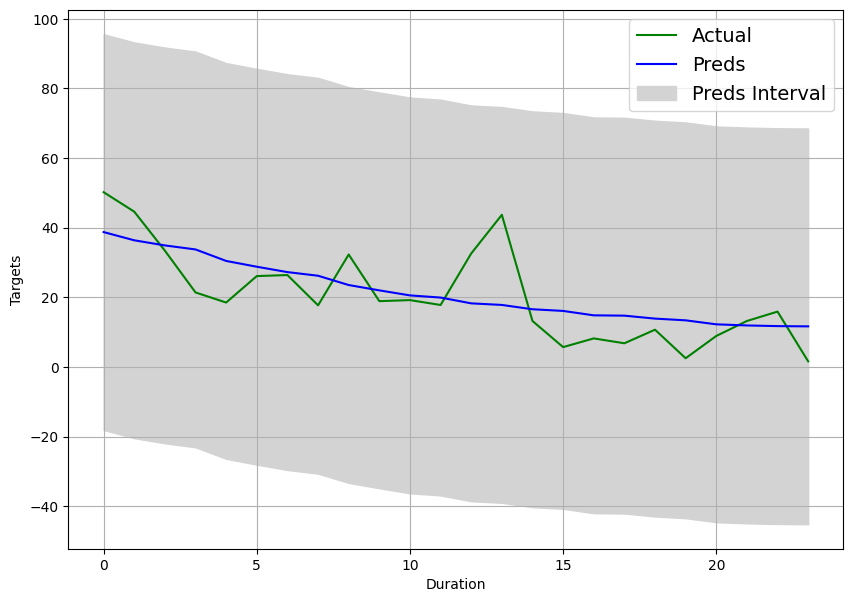

In [57]:
plot_ts_rg_preds_interval(y_val_unscaled, model_1_preds_unscaled, offset)

In [58]:
tf.keras.backend.clear_session()
inputs = layers.Input(shape=(WINDOW, 1), dtype=tf.float32)
x = layers.Conv1D(64, 3, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(72, activation="relu", return_sequences=True)(x)
x = layers.LSTM(48, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(HORIZON)(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")

model_2_init_weights = model_2.get_weights()

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2_history = model_2.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=100,
                              callbacks=[lr_scheduler_cb(1e-8, 20)])

Epoch 1/100
80/80 [==============================] - 6s 49ms/step - loss: 0.2012 - val_loss: 0.2236 - lr: 1.0000e-08
Epoch 2/100
80/80 [==============================] - 4s 46ms/step - loss: 0.2011 - val_loss: 0.2236 - lr: 1.1220e-08
Epoch 3/100
80/80 [==============================] - 4s 47ms/step - loss: 0.2011 - val_loss: 0.2236 - lr: 1.2589e-08
Epoch 4/100
80/80 [==============================] - 4s 48ms/step - loss: 0.2009 - val_loss: 0.2235 - lr: 1.4125e-08
Epoch 5/100
80/80 [==============================] - 4s 48ms/step - loss: 0.2010 - val_loss: 0.2235 - lr: 1.5849e-08
Epoch 6/100
80/80 [==============================] - 4s 49ms/step - loss: 0.2009 - val_loss: 0.2235 - lr: 1.7783e-08
Epoch 7/100
80/80 [==============================] - 4s 50ms/step - loss: 0.2010 - val_loss: 0.2234 - lr: 1.9953e-08
Epoch 8/100
80/80 [==============================] - 4s 53ms/step - loss: 0.2010 - val_loss: 0.2234 - lr: 2.2387e-08
Epoch 9/100
80/80 [==============================] - 4s 51ms/ste

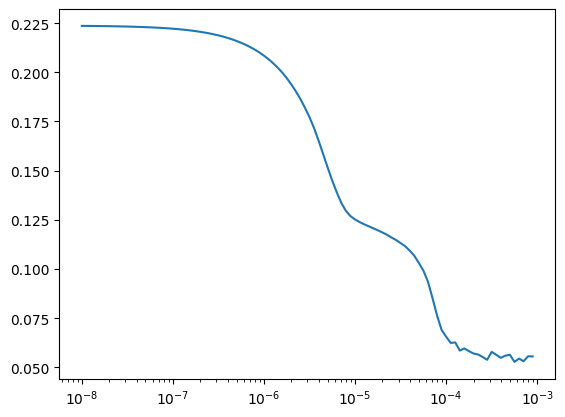

In [59]:
lrs = 1e-8 * 10 ** (tf.range(100)/20)
plt.semilogx(lrs, model_2_history.history["val_loss"])

In [60]:
model_2.set_weights(model_2_init_weights)

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

model_2_history = model_2.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=150,
                              callbacks=[tensorboard_cb("model_logs/sunspot/", model_2.name),
                                         checkpoint_cb("h5_models/sunspot/", model_2.name, save_format=".h5"),
                                         reduce_lr_cb(patience=3, factor=0.1),
                                         early_stopping_cb(patience=5)])

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 0.1488
Epoch 1: val_loss improved from inf to 0.12993, saving model to h5_models/sunspot\model_2.h5
80/80 [==============================] - 6s 50ms/step - loss: 0.1488 - val_loss: 0.1299 - lr: 1.0000e-04
Epoch 2/150
79/80 [============================>.] - ETA: 0s - loss: 0.1172
Epoch 2: val_loss improved from 0.12993 to 0.12191, saving model to h5_models/sunspot\model_2.h5
80/80 [==============================] - 4s 46ms/step - loss: 0.1168 - val_loss: 0.1219 - lr: 1.0000e-04
Epoch 3/150
80/80 [==============================] - ETA: 0s - loss: 0.1117
Epoch 3: val_loss improved from 0.12191 to 0.11736, saving model to h5_models/sunspot\model_2.h5
80/80 [==============================] - 4s 50ms/step - loss: 0.1117 - val_loss: 0.1174 - lr: 1.0000e-04
Epoch 4/150
79/80 [============================>.] - ETA: 0s - loss: 0.1082
Epoch 4: val_loss improved from 0.11736 to 0.11242, saving model to h5_models/sunspot\model_2.

In [154]:
tf.keras.backend.clear_session()
inputs = layers.Input(shape=(WINDOW, 1), dtype=tf.float32)
x = layers.Conv1D(64, 6, activation="relu")(inputs)
x = layers.Conv1D(64, 3, activation="relu")(x)
x = layers.LSTM(72, activation="relu", return_sequences=True)(x)
x = layers.LSTM(48, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(HORIZON)(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")

model_3_init_weights = model_2.get_weights()

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3_history = model_3.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=150,
                              callbacks=[tensorboard_cb("model_logs/sunspot/", model_3.name),
                                         checkpoint_cb("h5_models/sunspot/", model_3.name, save_format=".h5"),
                                         reduce_lr_cb(patience=3, factor=0.1),
                                         early_stopping_cb(patience=5)])

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 0.1143
Epoch 1: val_loss improved from inf to 0.07189, saving model to h5_models/sunspot\model_3.h5
80/80 [==============================] - 19s 211ms/step - loss: 0.1143 - val_loss: 0.0719 - lr: 0.0010
Epoch 2/150
80/80 [==============================] - ETA: 0s - loss: 0.0729
Epoch 2: val_loss improved from 0.07189 to 0.05933, saving model to h5_models/sunspot\model_3.h5
80/80 [==============================] - 17s 214ms/step - loss: 0.0729 - val_loss: 0.0593 - lr: 0.0010
Epoch 3/150
80/80 [==============================] - ETA: 0s - loss: 0.0663
Epoch 3: val_loss improved from 0.05933 to 0.05368, saving model to h5_models/sunspot\model_3.h5
80/80 [==============================] - 20s 257ms/step - loss: 0.0663 - val_loss: 0.0537 - lr: 0.0010
Epoch 4/150
80/80 [==============================] - ETA: 0s - loss: 0.0643
Epoch 4: val_loss did not improve from 0.05368
80/80 [==============================] - 20s 256ms/st

In [158]:
model_3_preds = model_3.predict(val_dataset)
model_3_results_scaled = evaluate_ts_rg_model(tf.cast(tf.squeeze(y_val_scaled), dtype=tf.float32), 
                                              tf.squeeze(model_3_preds))
model_3_results_scaled

C:\Users\yihim\AppData\Local\Temp\ipykernel_3832\3564251472.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100


{'MAE': 0.043008756,
 'MSE': 0.0034863502,
 'RMSE': 0.059045322,
 'MAPE': 52.85371541976929,
 'R2': 0.881210497278466}

In [159]:
model_3_results_unscaled = evaluate_ts_rg_model(tf.cast(tf.squeeze(y_scalar.inverse_transform(y_val_scaled)), dtype=tf.float32), tf.squeeze(y_scalar.inverse_transform(model_3_preds)))

C:\Users\yihim\AppData\Local\Temp\ipykernel_3832\3564251472.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100


In [160]:
model_3_results_unscaled

{'MAE': 17.126087,
 'MSE': 552.80695,
 'RMSE': 23.511847,
 'MAPE': 52.85371541976929,
 'R2': 0.8812104989731928}

In [168]:
offset = np.abs(60-len(tf.squeeze(model_3_preds)))
offset

580

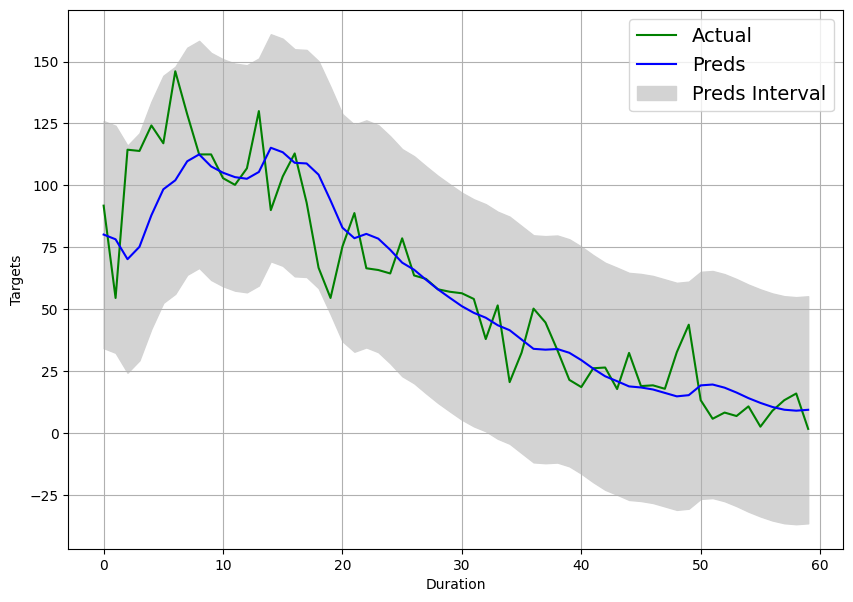

In [169]:
plot_ts_rg_preds_interval(tf.cast(tf.squeeze(y_scalar.inverse_transform(y_val_scaled)), dtype=tf.float32), 
                          tf.squeeze(y_scalar.inverse_transform(model_3_preds)),
                          offset)

In [171]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(WINDOW, 1), dtype=tf.float32)
x = layers.Conv1D(16, 3, activation="relu", padding="causal")(inputs)
x = layers.Bidirectional(layers.LSTM(16, activation="relu"))(x)
x = layers.Dense(16)(x)
outputs = layers.Dense(HORIZON)(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model_4_history = model_4.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=150,
                              callbacks=[tensorboard_cb("model_logs/sunspot/", model_4.name),
                                         checkpoint_cb("h5_models/sunspot/", model_4.name, save_format=".h5"),
                                         early_stopping_cb(patience=5),
                                         reduce_lr_cb(patience=3, factor=0.1)])

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 0.1009
Epoch 1: val_loss improved from inf to 0.06495, saving model to h5_models/sunspot\model_4.h5
80/80 [==============================] - 21s 233ms/step - loss: 0.1009 - val_loss: 0.0649 - lr: 0.0010
Epoch 2/150
80/80 [==============================] - ETA: 0s - loss: 0.0547
Epoch 2: val_loss improved from 0.06495 to 0.04664, saving model to h5_models/sunspot\model_4.h5
80/80 [==============================] - 19s 232ms/step - loss: 0.0547 - val_loss: 0.0466 - lr: 0.0010
Epoch 3/150
80/80 [==============================] - ETA: 0s - loss: 0.0513
Epoch 3: val_loss improved from 0.04664 to 0.04658, saving model to h5_models/sunspot\model_4.h5
80/80 [==============================] - 20s 252ms/step - loss: 0.0513 - val_loss: 0.0466 - lr: 0.0010
Epoch 4/150
80/80 [==============================] - ETA: 0s - loss: 0.0517
Epoch 4: val_loss did not improve from 0.04658
80/80 [==============================] - 20s 247ms/st

KeyboardInterrupt: 

In [172]:
model_4_loaded = tf.keras.models.load_model("h5_models/sunspot/model_4.h5")
model_4_preds = model_4.predict(val_dataset)
model_4_results_unscaled = evaluate_ts_rg_model(tf.cast(tf.squeeze(y_scalar.inverse_transform(y_val_scaled)), 
                                                        dtype=tf.float32), 
                                                tf.squeeze(y_scalar.inverse_transform(model_4_preds)))

C:\Users\yihim\AppData\Local\Temp\ipykernel_3832\3564251472.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100


In [173]:
model_4_results_unscaled

{'MAE': 17.445255,
 'MSE': 563.61426,
 'RMSE': 23.74056,
 'MAPE': 46.36359512805939,
 'R2': 0.8788881799061055}

In [175]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(WINDOW, 1), dtype=tf.float32)
x = layers.LSTM(50, activation="relu", return_sequences=True)(inputs)
x = layers.LSTM(25, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3))

model_5_history = model_5.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=150,
                              callbacks=[tensorboard_cb("model_logs/sunspot/", model_5.name),
                                         checkpoint_cb("h5_models/sunspot/", model_5.name, save_format=".h5"),
                                         early_stopping_cb(patience=5),
                                         reduce_lr_cb(patience=3, factor=0.1)])

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 0.0907
Epoch 1: val_loss improved from inf to 0.05753, saving model to h5_models/sunspot\model_5.h5
80/80 [==============================] - 21s 239ms/step - loss: 0.0907 - val_loss: 0.0575 - lr: 0.0050
Epoch 2/150
80/80 [==============================] - ETA: 0s - loss: 0.0669
Epoch 2: val_loss improved from 0.05753 to 0.05262, saving model to h5_models/sunspot\model_5.h5
80/80 [==============================] - 20s 248ms/step - loss: 0.0669 - val_loss: 0.0526 - lr: 0.0050
Epoch 3/150
80/80 [==============================] - ETA: 0s - loss: 0.0630
Epoch 3: val_loss improved from 0.05262 to 0.04997, saving model to h5_models/sunspot\model_5.h5
80/80 [==============================] - 19s 237ms/step - loss: 0.0630 - val_loss: 0.0500 - lr: 0.0050
Epoch 4/150
80/80 [==============================] - ETA: 0s - loss: 0.0600
Epoch 4: val_loss did not improve from 0.04997
80/80 [==============================] - 19s 244ms/st

KeyboardInterrupt: 

In [176]:
model_5_loaded = tf.keras.models.load_model("h5_models/sunspot/model_5.h5")
model_5_preds = model_5_loaded.predict(val_dataset)
model_5_results_unscaled = evaluate_ts_rg_model(tf.cast(tf.squeeze(y_scalar.inverse_transform(y_val_scaled)), 
                                                        dtype=tf.float32), 
                                                tf.squeeze(y_scalar.inverse_transform(model_5_preds)))

C:\Users\yihim\AppData\Local\Temp\ipykernel_3832\3564251472.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100


In [177]:
model_5_results_unscaled

{'MAE': 17.267925,
 'MSE': 550.7806,
 'RMSE': 23.468716,
 'MAPE': 66.19118452072144,
 'R2': 0.8816459347713131}

In [68]:
from tensorflow.keras import layers

def create_cv_nn():
    tf.keras.backend.clear_session()

    inputs = layers.Input(shape=(WINDOW, 1), dtype=tf.float32)
    x = layers.Conv1D(16, 3, activation="relu", padding="causal")(inputs)
    x = layers.Bidirectional(layers.LSTM(16, activation="relu"))(x)
    x = layers.Dense(16)(x)
    outputs = layers.Dense(HORIZON)(x)
    
    model = tf.keras.Model(inputs, outputs, name="model")

    model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3))

    return model

In [71]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

train_loss = []
val_loss = []

for train_index, test_index in tscv.split(X_train_scaled):
    print("Train indices:", train_index)
    print("\nTest indices:", test_index)

    X_train_split, X_test_split = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_split, y_test_split = y_train_scaled[train_index], y_train_scaled[test_index]

    model = create_cv_nn()
    
    model_history = model.fit(X_train_split, y_train_split, validation_data=(X_test_split, y_test_split), epochs=10)
    min_index = tf.argmin(model_history.history["val_loss"])
    tl = model_history.history["loss"][min_index]
    vl = model_history.history["val_loss"][min_index]
    train_loss.append(tl)
    val_loss.append(vl)
    print(f"\nTrain loss: {tl}\n")
    print(f"Val loss: {vl}\n")
    

Train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242

In [75]:
print(f"Train loss: {np.mean(train_loss)} +- {np.std(train_loss)}")
print(f"Val loss: {np.mean(val_loss)} +- {np.std(val_loss)}")

Train loss: 0.049051455408334735 +- 0.006591453950224358
Val loss: 0.046043789386749266 +- 0.004910961832501545


In [73]:
train_loss

[0.06200368329882622,
 0.04378543049097061,
 0.04753585532307625,
 0.04641886055469513,
 0.045513447374105453]

In [74]:
val_loss

[0.03861187770962715,
 0.05306527018547058,
 0.04611498862504959,
 0.04338580742478371,
 0.04904100298881531]